In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

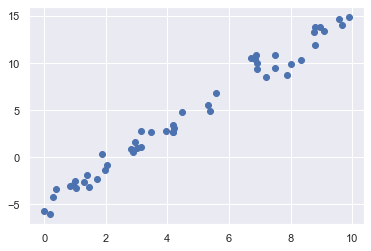

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

In [3]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], y)

LinearRegression()

In [4]:
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

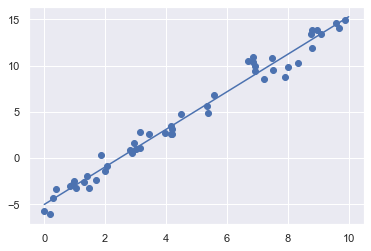

In [5]:
plt.scatter(x, y)
plt.plot(xfit, yfit);

In [6]:
print("Model slope:    ", model.coef_[0])
print("Intercept:    ", model.intercept_)

Model slope:     2.0272088103606953
Intercept:     -4.998577085553204


In [7]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.50000000000001
[ 1.5 -2.   1. ]


## Basis Functions

### Polynomial basis functions

In [8]:
from sklearn.preprocessing import PolynomialFeatures

x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [9]:
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(PolynomialFeatures(7), LinearRegression())

In [10]:
poly_model

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=7)),
                ('linearregression', LinearRegression())])

In [11]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

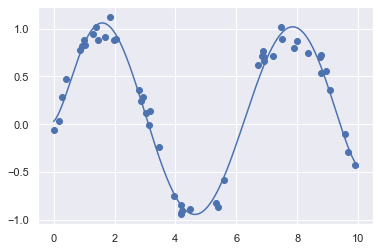

In [12]:
poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

### Gaussian basis functions

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input."""

    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        # create N centers spread along data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, np.newaxis], self.centers_, self.width_, axis=1)

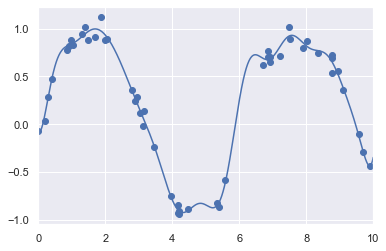

In [39]:
gauss_model = make_pipeline(GaussianFeatures(20), LinearRegression())
gauss_model.fit(x[:,np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

### Regularization

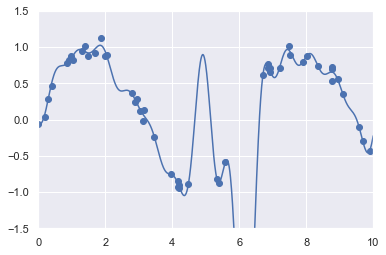

In [42]:
model = make_pipeline(GaussianFeatures(30), LinearRegression())
model.fit(x[:,np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))
plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

In [48]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)
    
    ax[1].plot(model.steps[0][1].centers_, model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location', ylabel='coefficient', xlim=(0, 10))

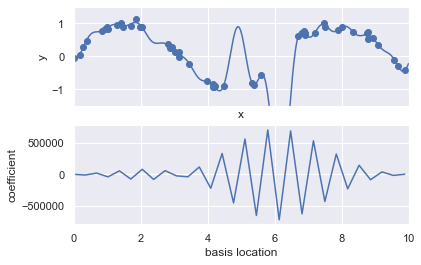

In [49]:
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

### Ridge Regression ($L_2$ regularization)

$$
P = \alpha * \sum_{n=1}^N \theta_n^2
$$

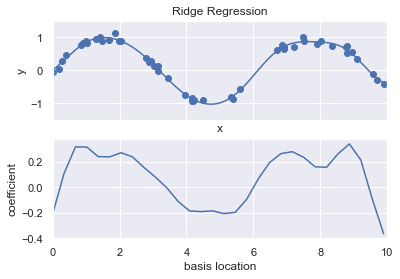

In [56]:
from sklearn.linear_model import Ridge

model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

In [58]:
model.steps[1][1].coef_

array([-0.21105794,  0.10862732,  0.31824548,  0.31676161,  0.2418113 ,
        0.24003021,  0.27210133,  0.23947825,  0.15675484,  0.08094844,
       -0.00307864, -0.11134067, -0.18560261, -0.19090305, -0.18482812,
       -0.20657632, -0.19638464, -0.09387141,  0.06369053,  0.1945448 ,
        0.26527119,  0.28056559,  0.23593141,  0.16159984,  0.15753808,
        0.26372747,  0.34134295,  0.21541902, -0.09008851, -0.36548691])

### Lasso regularization ($L_1$)

$$
P = \alpha * \sum_{n=1}^N|\theta_n|
$$

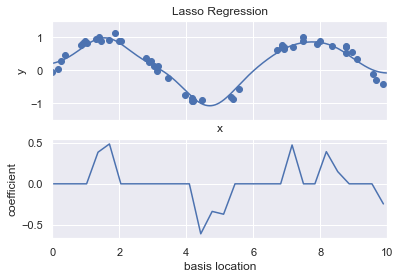

In [61]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.01))
basis_plot(model, title='Lasso Regression')

In [62]:
model.steps[1][1].coef_

array([-0.        , -0.        ,  0.        ,  0.        ,  0.38766282,
        0.48875038,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.61249839, -0.33800765,
       -0.37222013, -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.47588236,  0.        ,  0.        ,  0.39434033,
        0.14967478,  0.        ,  0.        , -0.        , -0.24613726])

### Predicting Bicycle Traffic

In [67]:
# !curl -o FremontBridge.csv 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'

In [144]:
import pandas as pd
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [145]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove_other_columns
daily = daily[daily.index < '2015-06-30']

In [146]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [147]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [148]:
import datetime
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - datetime.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

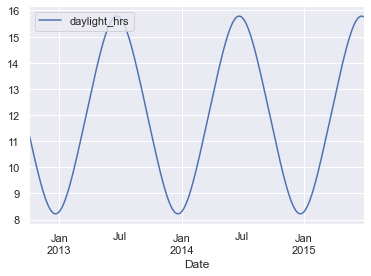

In [149]:
daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.legend(loc='upper left');

In [150]:
# temperature are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# converting precip from 1/10 mm to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [151]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [152]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1,0.000000
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1,0.002740
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1,0.005479
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1,0.008219
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1,0.010959


In [153]:
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday', 'daylight_hrs',
                'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

In [154]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

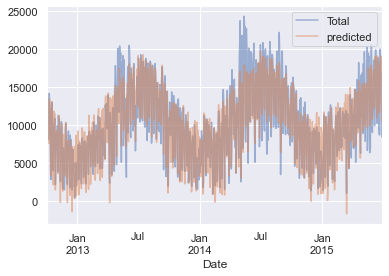

In [160]:
daily[['Total', 'predicted']].plot(alpha=0.5);

In [161]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon             1759.523449
Tue             2109.263386
Wed             2023.969709
Thu             1623.436516
Fri              467.246718
Sat            -4554.428585
Sun            -4701.757492
holiday        -4607.886758
daylight_hrs     501.233453
PRCP           -2640.487158
dry day         2229.897110
Temp (C)         282.981633
annual           255.158886
dtype: float64

In [170]:
from sklearn.utils import resample

np.random.seed(1)
err = np.std([model.fit(*resample(X,y)).coef_ for i in range(1000)], 0)

In [172]:
print(pd.DataFrame({'effect': params.round(0), 'error': err.round(0)}))

              effect  error
Mon           1760.0  351.0
Tue           2109.0  336.0
Wed           2024.0  330.0
Thu           1623.0  349.0
Fri            467.0  332.0
Sat          -4554.0  340.0
Sun          -4702.0  338.0
holiday      -4608.0  651.0
daylight_hrs   501.0   35.0
PRCP         -2640.0  251.0
dry day       2230.0  139.0
Temp (C)       283.0   14.0
annual         255.0   72.0
